<a href="https://colab.research.google.com/github/miryalavarshitha/AICTE__INTERNSHIP/blob/main/week-2_garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: import dataset from drive

import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your dataset file in Google Drive
# Replace 'My Drive/path/to/your/dataset.csv' with the actual path
file_path = '/content/drive/My Drive/Colab Notebooks/archive.zip'

# Read the dataset using pandas (assuming it's a CSV file)
# You can use other pandas functions like read_excel, read_json, etc. depending on your file type
try:
    # Check if the file exists before attempting to read
    import os
    if os.path.exists(file_path):
        # Assuming the archive.zip contains a CSV file, you'll need to extract it first.
        # If it's a single CSV inside the zip, you can use pandas.read_csv directly on the zip file.
        # However, if there are multiple files or it's not a CSV, you'll need to unzip it.

        # Let's assume it's a zip containing images for now, based on the rest of the notebook.
        # The unzipping is handled in cell 6yNBmXqokblw, which expects the zip at /archive.zip
        # We need to copy the zip file from Drive to /archive.zip

        !cp "{file_path}" /archive.zip
        print(f"Copied {file_path} to /archive.zip")

        # The rest of the notebook assumes the data is in /garbage_dataset after unzipping
        # So, the dataframe loading part is not needed for this notebook's flow.
        # I will comment out the dataframe loading part as it seems irrelevant to the rest of the code.

        # df = pd.read_csv(file_path)
        # print("Dataset loaded successfully:")
        # print(df.head()) # Print the first few rows to verify
    else:
        print(f"Error: The file was not found at {file_path}")

except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive
Copied /content/drive/My Drive/Colab Notebooks/archive.zip to /archive.zip


In [3]:
import zipfile
import os

zip_path = "drive/MyDrive/Colab Notebooks/archive.zip"
extract_path = "drive/MyDrive/Colab Notebooks/garbage_dataset"

# Create the folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file into the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Unzipped successfully to: {extract_path}")

Unzipped successfully to: drive/MyDrive/Colab Notebooks/garbage_dataset


In [4]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [8]:
dataset_dir= r"drive/MyDrive/Colab Notebooks/garbage_dataset/TrashType_Image_Dataset"
image_size = (260, 260)
batch_size = 32
seed = 42

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [11]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [12]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


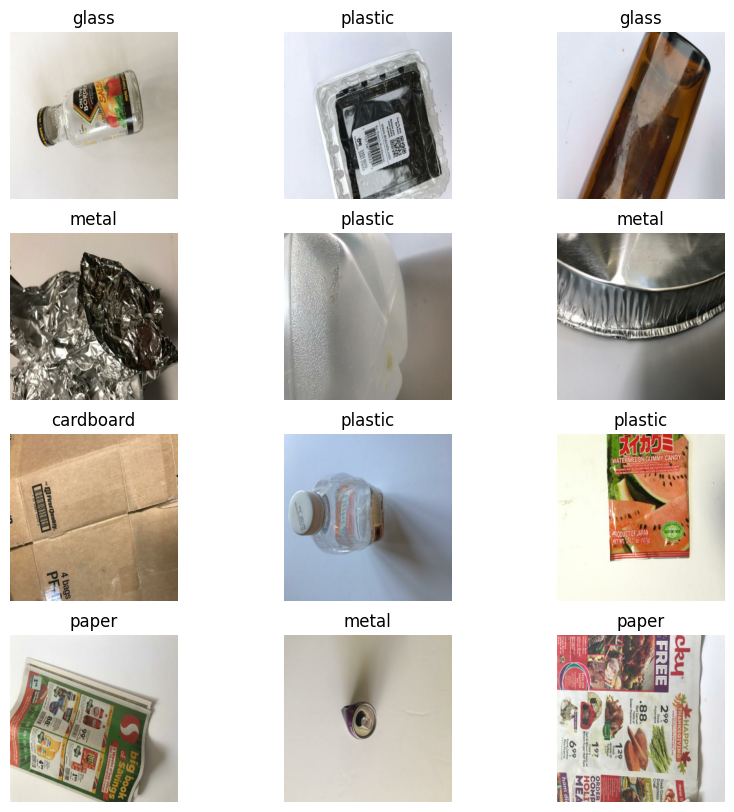

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [14]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts


In [15]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [16]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


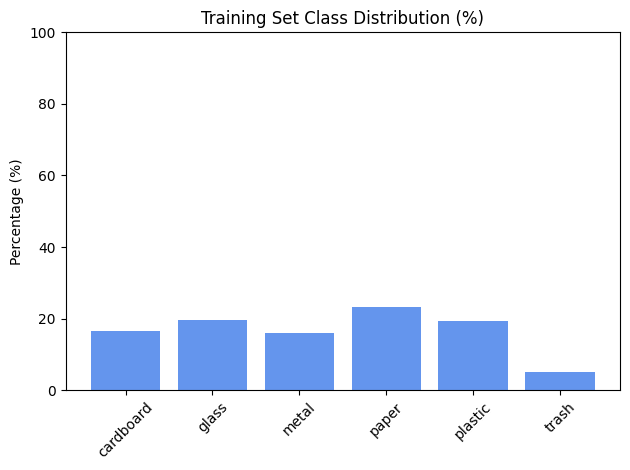

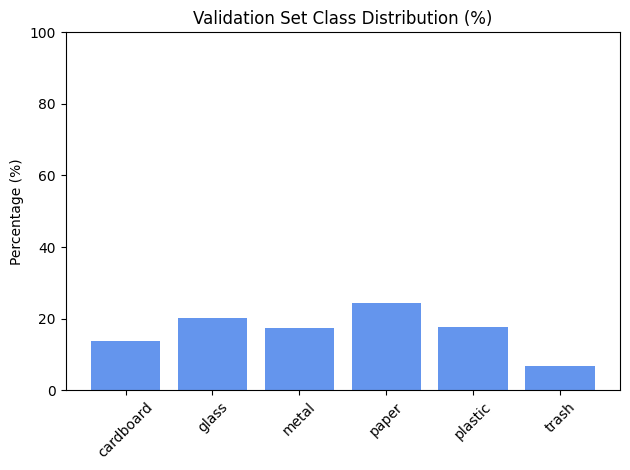

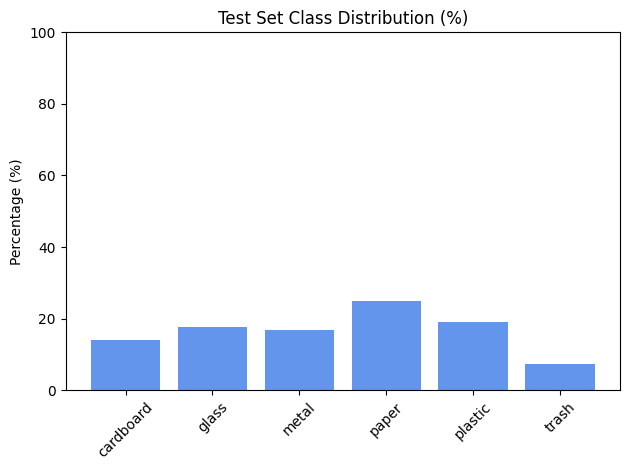

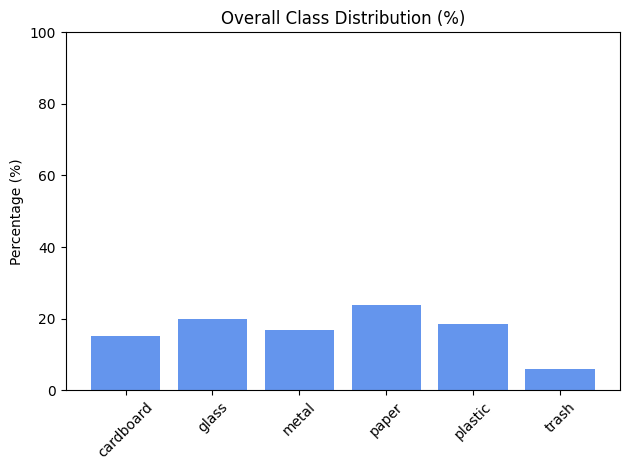

In [17]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [18]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [19]:
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


In [20]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [21]:
# #  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(260, 260, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
# for layer in base_model.layers[:100]:  # You can adjust this number
#     layer.trainable = False
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.layers import GlobalAveragePooling2D

# # Load full MobileNetV2 model without the top classification layer
# base_model = MobileNetV2(
#     include_top=False,
#     input_shape=(224, 224, 3),
#     weights='imagenet'
# )

# # Make all layers trainable
# base_model.trainable = True

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
# #  Build the final model
# model = Sequential([
#     layers.Input(shape=(124, 124, 3)),
#     data_augmentation,
#     base_model,
#     GlobalAveragePooling2D(),
#     layers.Dropout(0.3),
#     layers.Dense(6, activation='softmax')  # Change to your number of classes
# ])
# Build the model
model = Sequential([
    data_augmentation,  # Define this beforehand (e.g., tf.keras.Sequential([...]))
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change 6 to match your number of classes
])

In [23]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [26]:
# Set the number of epochs to train the model
epochs =  20 # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_dat,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 111s 635ms/step - accuracy: 0.3857 - loss: 1.5788 - val_accuracy: 0.7390 - val_loss: 0.9653
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 556ms/step - accuracy: 0.7582 - loss: 0.8263 - val_accuracy: 0.8313 - val_loss: 0.5432
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 552ms/step - accuracy: 0.8554 - loss: 0.4782 - val_accuracy: 0.8956 - val_loss: 0.3252
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 558ms/step - accuracy: 0.9018 - loss: 0.2893 - val_accuracy: 0.9116 - val_loss: 0.2747
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 548ms/step - accuracy: 0.9500 - loss: 0.1981 - val_accuracy: 0.9197 - val_loss: 0.2338
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 566ms/step - accuracy: 0.9419 - loss: 0.1644 - val_accuracy: 0.9398 - val_loss: 0.1932
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 559ms/step - accuracy: 0.9695 - loss: 0.1016 - val_accuracy: 0.9237 - val_loss: 0.2736
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 556ms/step - accuracy: 0.9675 - loss: 0.0990 - val_acc

In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,168,910 (99.83 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

 Optimizer params: 17,391,082 (66.34 MB)

In [28]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

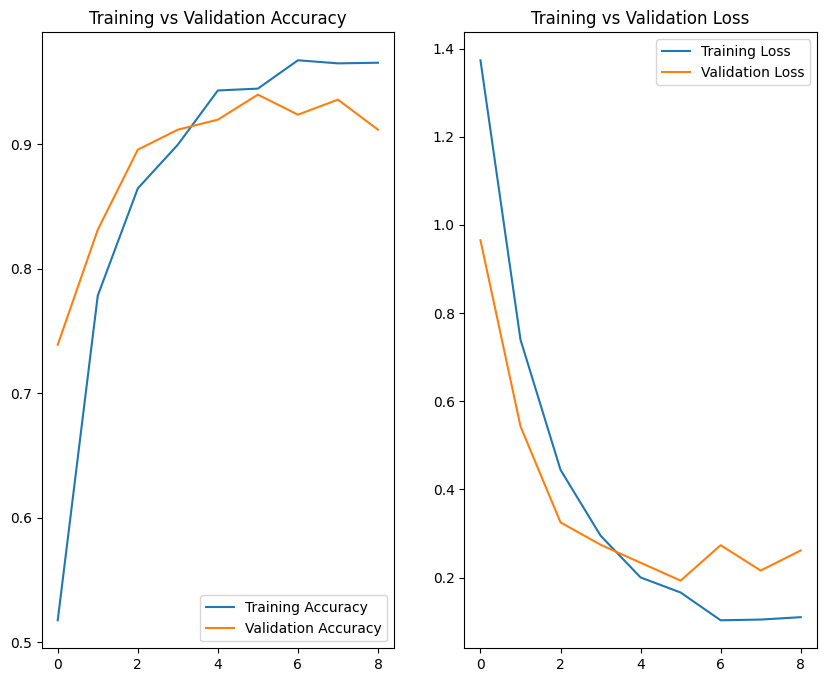

In [29]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

In [30]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9341 - loss: 0.1765
Test accuracy is0.9375, Test loss is 0.1917


In [31]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step
[[33  0  0  4  0  0]
 [ 0 49  5  0  2  0]
 [ 0  0 37  0  0  0]
 [ 0  0  0 61  0  1]
 [ 0  1  0  0 39  3]
 [ 0  0  0  0  0 21]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        37
           1       0.98      0.88      0.92        56
           2       0.88      1.00      0.94        37
           3       0.94      0.98      0.96        62
           4       0.95      0.91      0.93        43
           5       0.84      1.00      0.91        21

    accuracy                           0.94       256
   macro avg       0.93      0.94      0.93       256
weighted avg       0.94      0.94      0.94       256



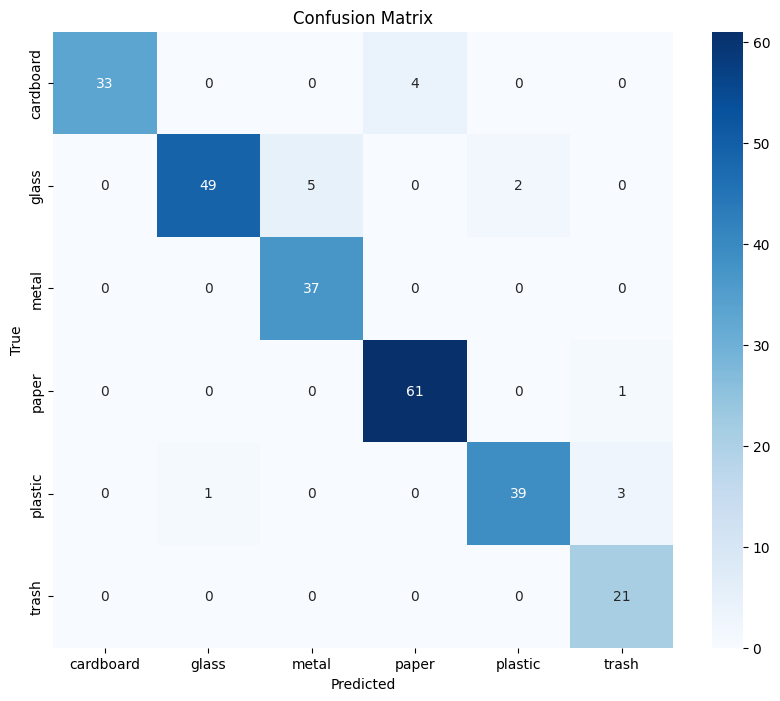

In [32]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


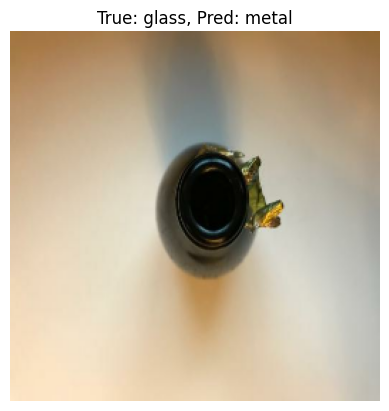

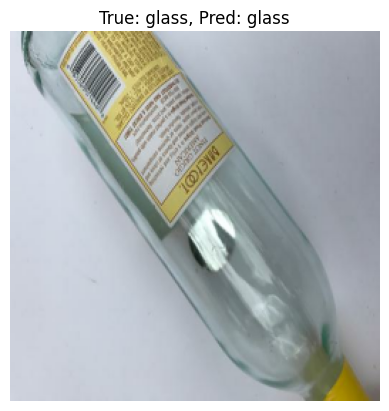

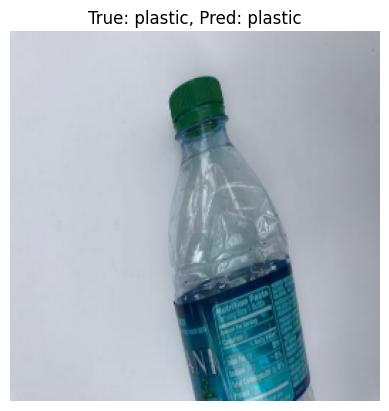

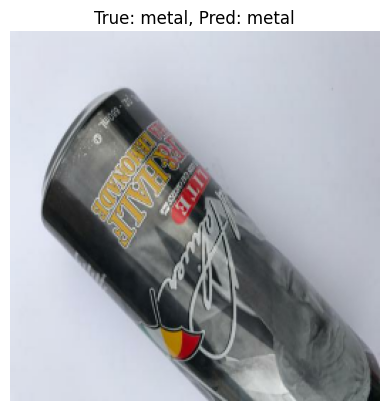

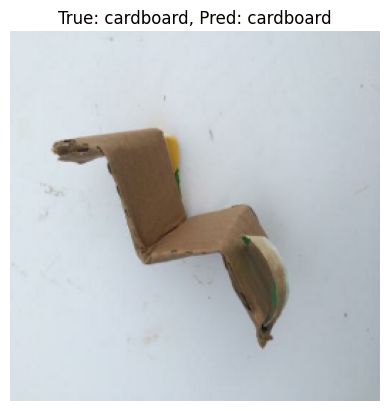

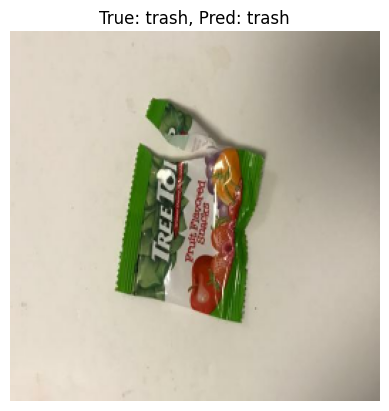

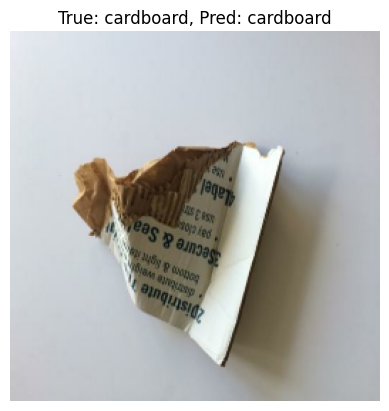

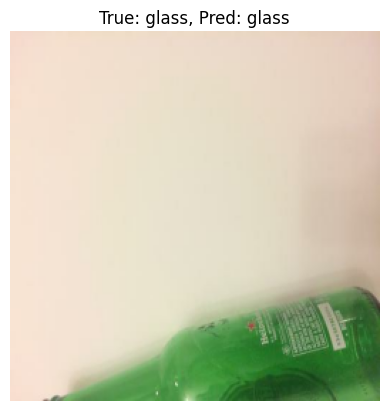

In [33]:
# Extract class names from the training dataset
class_names = train_ds.class_names

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):

    # Generate predictions for the batch of images
    predictions = model.predict(images)

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)

    # Loop through the first 8 images in the batch
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [40]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('drive/MyDrive/ML Projects/Garbage Collection/Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/Effiicientnetv2b2.keras')

In [ ]:
!pip install gradio

In [35]:
# ✅ Install necessary packages
#!pip install --upgrade gradio tensorflow pillow

# ✅ Import Libraries
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from PIL import Image

# ✅ Load Trained Model
model = load_model("drive/MyDrive/Colab Notebooks/Effiicientnetv2b2.keras")
class_names = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Organic']

# ✅ Image Classification Function
def classify_image(img):
    img = img.resize((124, 124))
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index]
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

# ✅ Jarvis Chatbot Response Logic
def chatbot_response(question):
    q = (question or "").lower()
    if "hello" in q or "hi" in q:
        return "Hello! I'm Jarvis 😊. How can I assist you?"
    elif "accuracy" in q:
        return "Our garbage classification model achieved a training accuracy of 89.17% and a test accuracy of 90.23% using CNN and EfficientNet B0."
    elif "dataset" in q:
        return "We trained on a labeled garbage image dataset with categories like Plastic, Paper, Metal, Glass, and Organic Waste."
    elif "model" in q or "technology" in q:
        return "We used CNN with EfficientNet architecture."
    elif "libraries" in q:
        return "Libraries used: TensorFlow, Keras, NumPy, and Gradio."
    elif "features" in q:
        return "Features: Image upload, webcam input, real-time classification, and an interactive chatbot."
    elif "use case" in q or "application" in q:
        return "Use cases: Smart Bins, City Waste Management, Recycling Plants, Mobile Apps."
    elif "purpose" in q:
        return "The purpose is to automate garbage classification for smart cities and eco-friendly waste sorting."
    elif "requirement" in q:
        return "Requirements: Python, TensorFlow, Gradio, and a labeled image dataset."
    elif "end" in q or "close" in q:
        return "Chat ended. Have a great day! 😊"
    else:
        return "I'm Jarvis 🤖. Ask me about accuracy, dataset, model, features, libraries, or purpose!"

# ✅ Custom CSS for Styling
css_code = """
body {
    font-family: 'Segoe UI', sans-serif;
    background-color: #f5f5f5;
    color: #333;
}
.navbar, .footer {
    background-color: #4CAF50;
    color: white;
    padding: 15px;
}
.navbar {
    display: flex;
    justify-content: space-between;
    align-items: center;
}
.nav-links {
    display: flex;
    gap: 20px;
}
.nav-link {
    cursor: pointer;
    text-decoration: underline;
}
.card, .about-section {
    background-color: #dcedc8;
    border-radius: 10px;
    padding: 15px;
    margin: 10px 0;
    transition: transform 0.3s ease, box-shadow 0.3s ease;
    color:black;
}
.card:hover, .about-section:hover {
    transform: scale(1.02);
    box-shadow: 0 6px 12px rgba(0,0,0,0.2);
}
.cards-row {
    display: flex;
    gap:10px;
    overflow-x: auto;
    padding-bottom: 10px;

}
.floating-chat {
    position: fixed;
    bottom: 20px;
    right: 20px;
    background-color: #4CAF50;
    color: white;
    border-radius: 50%;
    width: 55px;
    height: 55px;
    display: flex;
    align-items: center;
    justify-content: center;
    font-size: 28px;
    cursor: pointer;
    box-shadow: 0 4px 8px rgba(0,0,0,0.3);
    z-index: 1000;
    animation: pulse 2s infinite;
}
@keyframes pulse {
    0% { transform: scale(1); }
    50% { transform: scale(1.1); }
    100% { transform: scale(1); }
}
#chatbox-container {
    position: fixed;
    bottom: 90px;
    right: 20px;
    width: 320px;
    background: white;
    border: 1px solid #ccc;
    border-radius: 10px;
    padding: 15px;
    display: none;
    z-index: 1000;
    box-shadow: 0 8px 16px rgba(0,0,0,0.2);
}
.footer-top {
    display: flex;
    justify-content: space-between;
    flex-wrap: wrap;
}
.footer-bottom {
    display: flex;
    justify-content: space-between;
    margin-top: 10px;
    font-size: 14px;
}
.social-icons{
  display:flex;
}
.social-icons img {
    width: 22px;
    height: 22px;
    margin-left: 10px;
}
"""

# ✅ Gradio UI Blocks
with gr.Blocks(css=css_code) as demo:
    # Navbar
    gr.HTML("""
    <div class='navbar'>
        <div><h2>Garbage Classification AI</h2></div>
        <div class='nav-links'>
            <span class='nav-link' onclick="document.getElementById('garbage').scrollIntoView({behavior:'smooth'});">Garbage Classification</span>
            <span class='nav-link' onclick="document.getElementById('about').scrollIntoView({behavior:'smooth'});">About Us</span>
            <span class='nav-link' onclick="document.getElementById('contact').scrollIntoView({behavior:'smooth'});">Contact</span>
        </div>
    </div>
    """)

    # Garbage Classification Section
    gr.HTML("<div id='garbage'></div>")
    gr.Markdown("## Garbage Classification")
    img_input = gr.Image(type="pil", label="Upload Image or Use Webcam", sources=["upload", "webcam"])
    result_output = gr.Textbox(label="AI Prediction")
    classify_btn = gr.Button("Classify")
    classify_btn.click(fn=classify_image, inputs=img_input, outputs=result_output)

    # About Us Section
    gr.HTML("<div id='about'></div>")
    gr.HTML("""
    <div class='about-section'>
        <h2>About the Project</h2>
        <p>This project focuses on automating garbage classification using Deep Learning techniques.
        A CNN with EfficientNet architecture achieved 90% validation accuracy and 90.23% test accuracy.
        Built with Python, TensorFlow, Keras, and NumPy, with a Gradio interface for image upload and real-time classification.
        An AI chatbot named Jarvis is also integrated for user queries.</p>
    </div>
    """)

    # Research Papers Section
    gr.Markdown("## Research Papers")
    gr.HTML("""
    <div class='cards-row '>
        <div class='card'>
            <h4>Multi-Scale CNN Based Garbage Detection</h4>
            <p>Introduces a Multi-Scale CNN (MSCNN) for garbage detection using airborne hyperspectral data.</p>
            <a href='https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8782106' target='_blank'>Read More</a>
        </div>
        <div class='card'>
            <h4>Garbage Classification Algorithm</h4>
            <p>Uses an improved MobileNetV3 model to enhance garbage classification accuracy and speed.</p>
            <a href='https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10478519' target='_blank'>Read More</a>
        </div>
        <div class='card'>
            <h4>Automatic Garbage Classification</h4>
            <p>ResNet-34 based deep learning model for automatic garbage classification with high reliability.</p>
            <a href='https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9144549' target='_blank'>Read More</a>
        </div>
    </div>
    """)

    # Contact Section
    gr.HTML("<div id='contact'></div>")
    gr.Markdown("## Contact Us")
    gr.Markdown("For further queries, contact: **miryalavarshitha@gmail.com**")

    # Jarvis Chatbox (Initially Hidden)
    with gr.Row(visible=False, elem_id="chatbox-container") as chatbox_container:
        gr.Markdown("**Jarvis 👋:** Hello! I'm Jarvis. Ask me about the project below:")
        jarvis_input = gr.Textbox(placeholder="Type your question...")
        jarvis_output = gr.Textbox(label="Jarvis Response", interactive=False)
        with gr.Row():
            send_btn = gr.Button("Send")
            close_btn = gr.Button("Close")
        def send_and_clear(q):
            resp = chatbot_response(q)
            return resp, ""
        send_btn.click(fn=send_and_clear, inputs=jarvis_input, outputs=[jarvis_output, jarvis_input])
        def close_chat():
            return gr.update(visible=False), "", ""
        close_btn.click(fn=close_chat, inputs=None, outputs=[chatbox_container, jarvis_input, jarvis_output])



    # Floating Chat Icon
    gr.HTML("""
    <div class='floating-chat' onclick="document.querySelector('[id*=chatbox-container]').style.display='block';
    document.querySelector('[id*=chatbox-container] textarea').value='Hello';
    document.querySelector('[id*=chatbox-container] button').click();">💬</div>
    """)

    # Footer
    gr.HTML("""
    <div class='footer'>
        <div class='footer-top'>
            <div>
                <h4>Miryala Varshitha</h4>
                <p>Garbage Classification AI</p>
            </div>
            <div>
                <h4>Social Links</h4>
                <div class='social-icons'>
                    <a href='https://facebook.com' target='_blank'><img src='https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg'></a>
                    <a href='https://instagram.com/_.miryalavarshitha._' target='_blank'><img src='https://upload.wikimedia.org/wikipedia/commons/a/a5/Instagram_icon.png'></a>
                </div>
            </div>
        </div>
        <div class='footer-bottom'>
            <div>&copy; 2025 Garbage Classification AI. All Rights Reserved.</div>
            <div>Designed by Miryala Varshitha</div>
        </div>
    </div>
    """)

# ✅ Launch Gradio App with Public Link (For Colab)
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f35bdd1143a94bb7e9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,168,910 (99.83 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

 Optimizer params: 17,391,082 (66.34 MB)